# Training loop for UNet with SE and res blocks
First training step is on patches of 512x512 cxrs, patch sizes should be 64x64.

In [1]:
# Colab setup

In [2]:
# Enviorment setup
import os
import torch
import numpy as np
import random

# Seeding
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# TODO (optional): fix xpu support
print("Using:", device)


Using: cpu


NIH CXR Dataset (512x512), split='train' loaded with 69791 samples
NIH CXR Dataset (512x512), split='val' loaded with 16733 samples
NIH CXR Dataset (512x512), split='test' loaded with 25596 samples
train/val/test: 69791/16733/25596
Sample batch shape: torch.Size([4, 1, 512, 512])


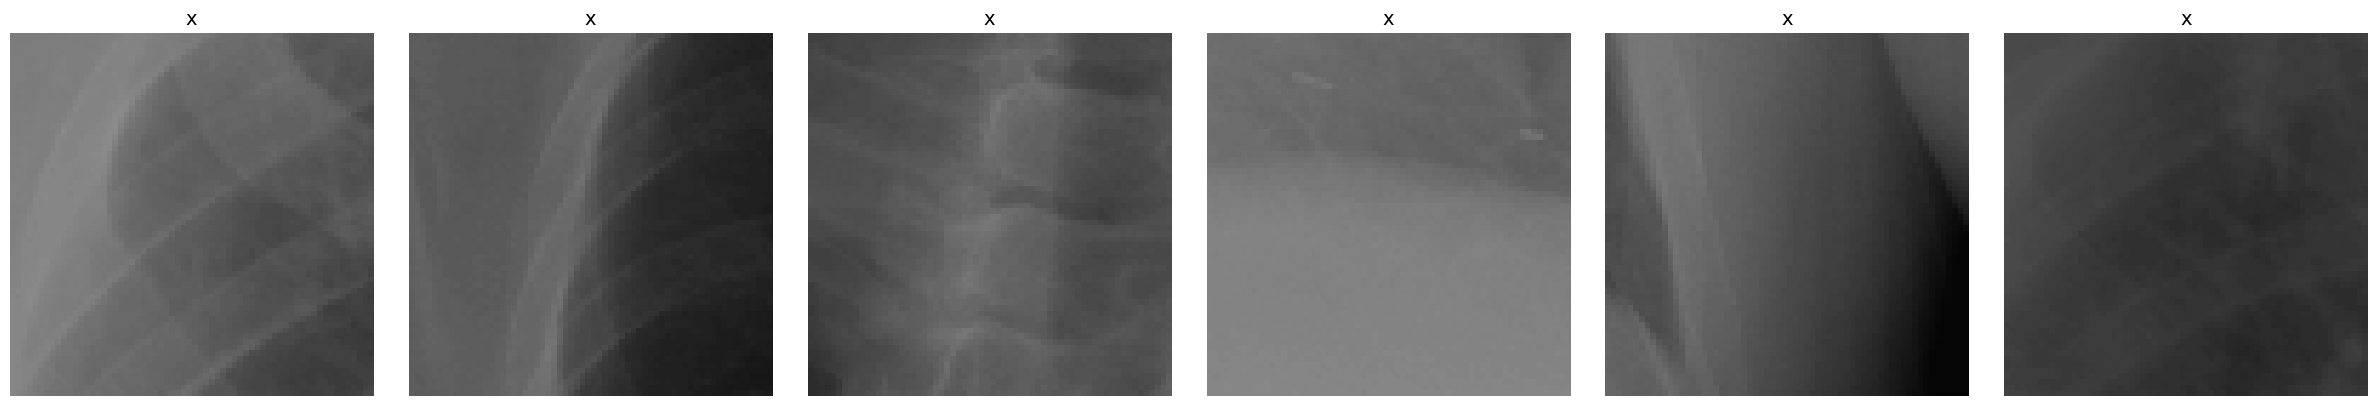

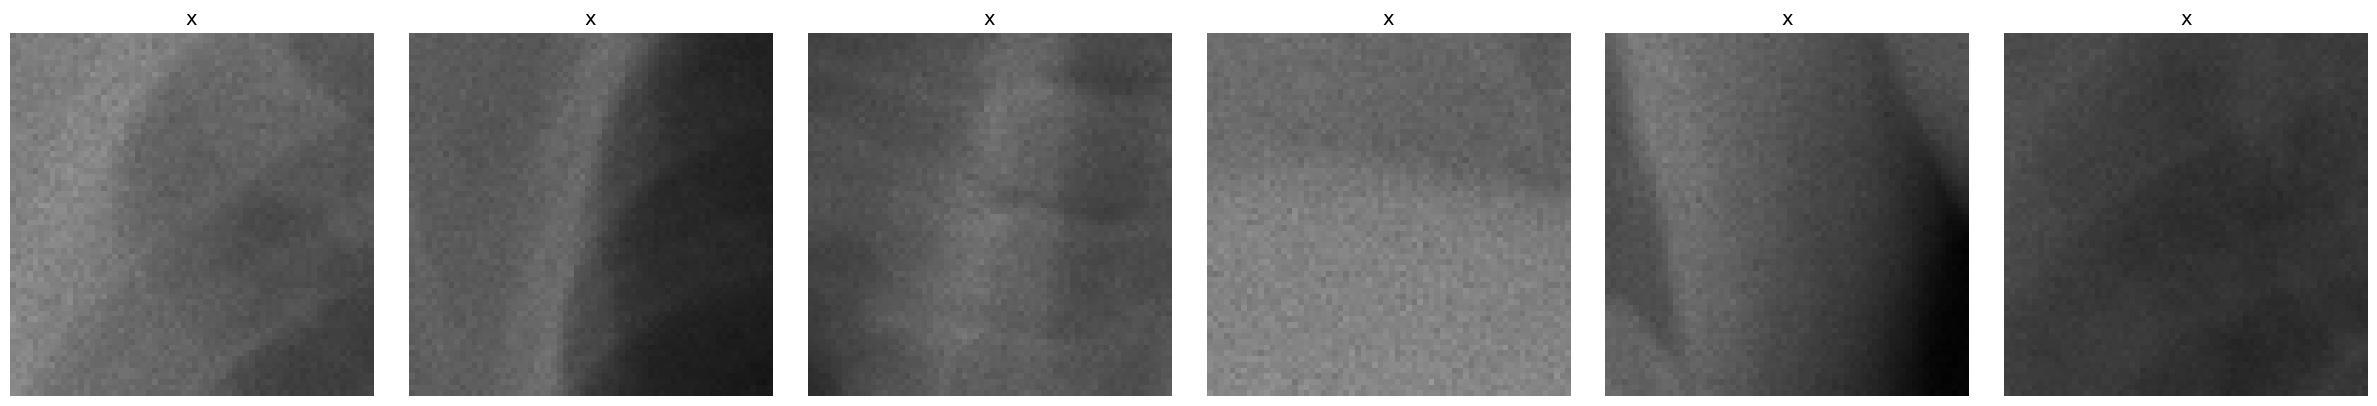

In [3]:
from nih_dataset import NIH_Dataset, RandomPatchDataset
from torch.utils.data import DataLoader
from noise import PreprocessClean, ApplyNoise
import torch
from PIL import Image
from torchvision import transforms

# Dataset
DATA_PATH = "../data/NIH_data_512"

nih_train = NIH_Dataset(DATA_PATH, split="train")
nih_val = NIH_Dataset(DATA_PATH, split="val")
nih_test = NIH_Dataset(DATA_PATH, split="test")

LIMIT_DATA = None # For Using Full Dataset
#LIMIT_DATA = [500, 300, None] # For Testing

if LIMIT_DATA:
    nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
    nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
    nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test

BATCH_SIZE = 4



train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)

PATCH_BATCH_SIZE = 32
PATCH_SIZE = 64

patch_train_dl = DataLoader(RandomPatchDataset(nih_train, PATCH_SIZE), batch_size=PATCH_BATCH_SIZE, pin_memory=True, num_workers=4)

print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")

preproc: PreprocessClean = PreprocessClean() # apply to clean images for ground truth
noiser: ApplyNoise = ApplyNoise(blur_sigma=1.0) # apply to preproc to get noisy features

sample = next(iter(train_dl))
print("Sample batch shape:", sample[0].shape)

# Load and transform images named example_01.png to example_06.png
example_transf = transforms.ToTensor()
example_patches = [
    example_transf(Image.open(f"examples/patch_{i:02d}.png").convert("L")) for i in range(1, 7)
]

# Stack into batch if needed
example_patch_batch = torch.stack(example_patches).to(device)  # shape: (6, 1, H, W)
import cxr_plt

a = preproc(example_patch_batch)
b = noiser(a)

cxr_plt.plot_cxr_images(a, ["x" for _ in range(6)], figsize=(4*6, 4))
cxr_plt.plot_cxr_images(b, ["x" for _ in range(6)], figsize=(4*6, 4))


In [4]:
# Model
from unet_model import ResUNetSE
import torchsummary
import torchinfo
import torch

model = ResUNetSE(features=32, se_reduction=16).to(device=device)

with torch.no_grad():
    out = model(torch.zeros((1, 1, 512, 512)).to(device))
    print("model output shape:", out.shape)


print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

c:\Users\Morris\Workspace\cxr-denoise\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model output shape: torch.Size([1, 1, 512, 512])
Trainable parameters: 8,169,711


Epoch 1/10:   5%|▍         | 99/2181 [01:37<31:46,  1.09it/s, loss=0.1051] 

checkup!


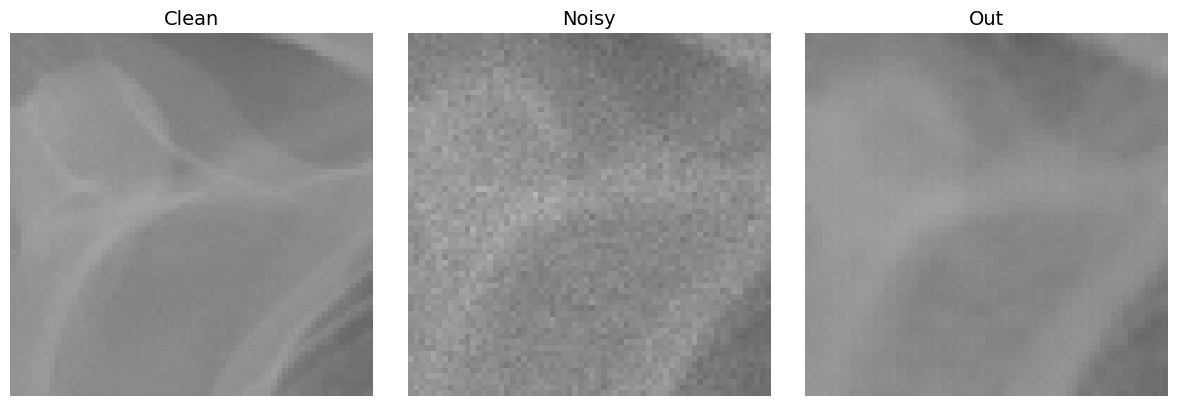

Epoch 1/10:   9%|▉         | 199/2181 [03:08<30:28,  1.08it/s, loss=0.0841]

checkup!


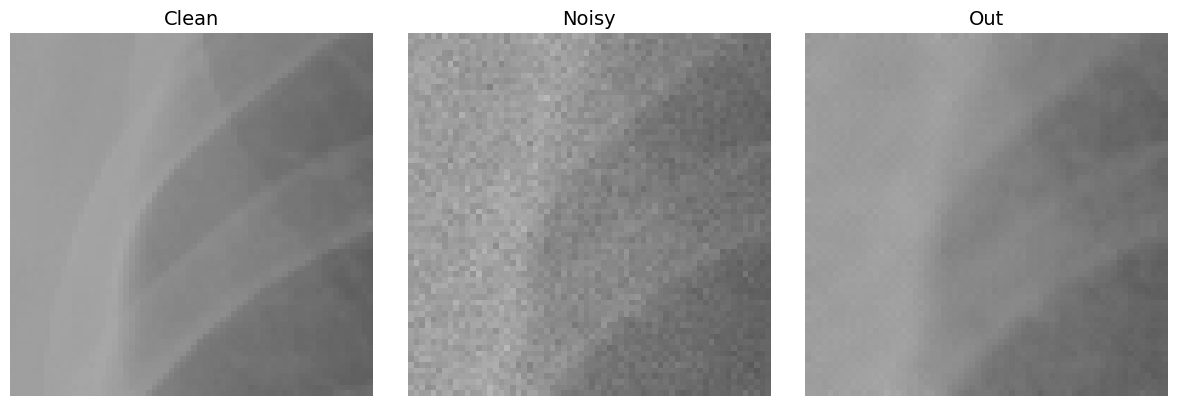

Epoch 1/10:  14%|█▎        | 299/2181 [04:38<27:56,  1.12it/s, loss=0.0835]

checkup!


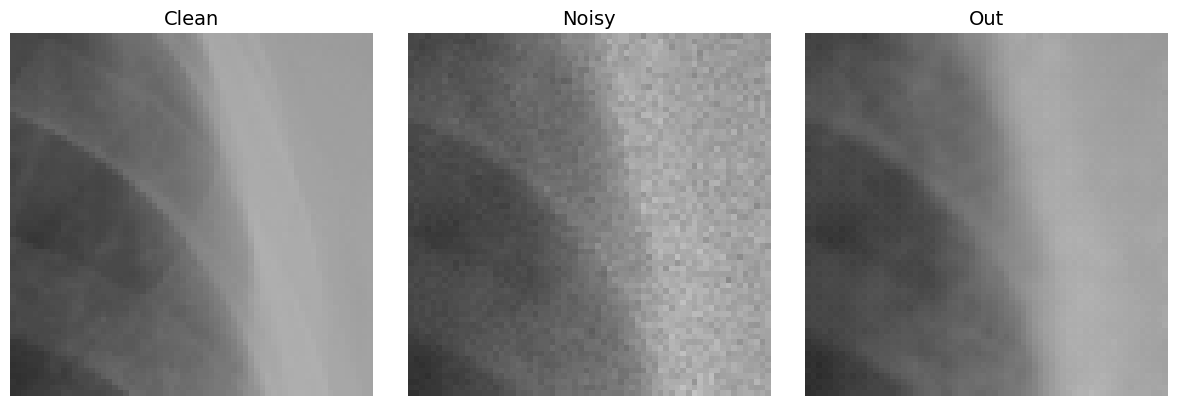

Epoch 1/10:  18%|█▊        | 399/2181 [06:08<28:37,  1.04it/s, loss=0.1123]

checkup!


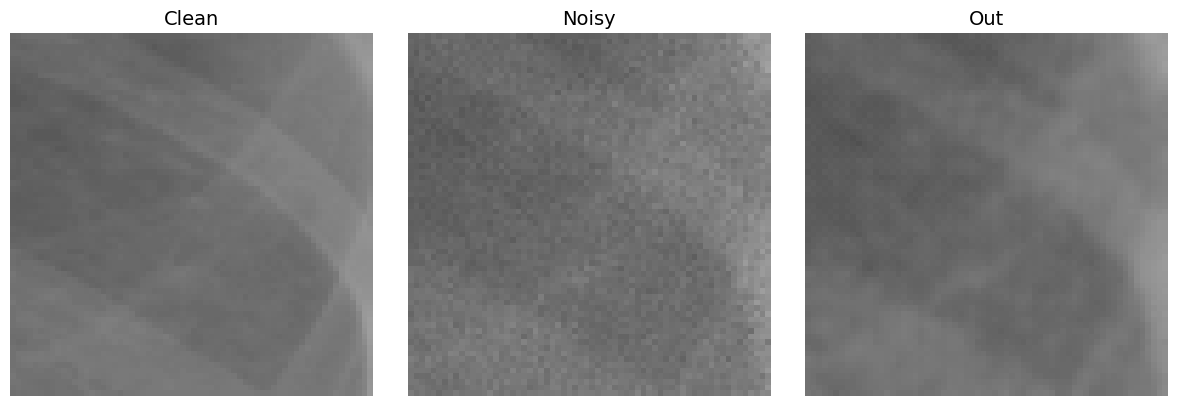

Epoch 1/10:  22%|██▏       | 477/2181 [07:26<27:45,  1.02it/s, loss=0.0781]

In [ ]:
# Training loop - patch training

import torch
from cxr_plt import *
from tqdm import tqdm
from loss import CombinedLoss, SpatialLoss, FrequencyLoss
import matplotlib.pyplot as plt
import os
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

from torchmetrics.functional import structural_similarity_index_measure as ssim
import torch.nn.functional as F
from train_util import *
import csv

criterion = CombinedLoss(1.0, 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
model.train()

num_epochs = 10
patch_size = 64



metrics_log_path = "checkpoints/training_metrics.csv"
os.makedirs("checkpoints", exist_ok=True)

# Create CSV file with header if not exists
if not os.path.exists(metrics_log_path):
    with open(metrics_log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "val_psnr", "val_ssim", "val_l1", "train_psnr", "train_ssim", "train_l1"])


total_batches = 0
for epoch in range(num_epochs):
    total_loss = 0
    pbar = tqdm(patch_train_dl, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in pbar:
        batch = batch[0] if isinstance(batch, (tuple, list)) else batch
        clean = batch.to(device)  # (B, 1, H, W)

        # Preprocess and noise
        clean = preproc(clean)

        # Apply noise
        noisy = noiser(clean)

        # Forward pass
        output = model(noisy)
        loss = criterion(output, clean)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_batches += 1

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

        if total_batches % 100 == 0:
            print("checkup!")
            plot_cxr_images([clean[0], noisy[0], output[0]], ["Clean", "Noisy", "Out"])

    # Log visuals and metrics after each epoch
    with torch.no_grad():
        model.eval()

        clean = preproc(example_patch_batch.to(device))
        noisy = noiser(clean)
        output = model(noisy)

        save_cxr_triplet(clean, noisy, output, f"example_patches_epoch_{epoch}.png")

        val_metrics = evaluate_metrics_on_dataloader(model, val_dl, preproc, noiser, device, max_batches=500)
        train_metrics = evaluate_metrics_on_dataloader(model, train_dl, preproc, noiser, device, max_batches=500)

        # Save model checkpoint
        torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1}.pt")

        # Write metrics to CSV
        with open(metrics_log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                val_metrics["psnr"],
                val_metrics["ssim"],
                val_metrics["l1"],
                train_metrics["psnr"],
                train_metrics["ssim"],
                train_metrics["l1"]
            ])


        model.train()

    avg_loss = total_loss / len(patch_train_dl)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

In [ ]:
import time
import torch

def profile_training_step(
    model,
    dataloader,
    preproc,
    noiser,
    criterion,
    optimizer,
    device="cuda",
    patch_size=64,
    num_batches=20
):
    model.train()
    times = {
        "load": 0.0,
        "preprocess": 0.0,
        "forward": 0.0,
        "backward": 0.0,
        "optimizer": 0.0
    }

    data_iter = iter(dataloader)

    for _ in range(num_batches):
        # --- Load from dataloader ---
        t0 = time.time()
        batch = next(data_iter)[0]  # already tensor
        t1 = time.time()

        clean = batch.to(device)

        # --- Preprocess & Noise ---
        clean_pre = preproc(clean)  # clipping/scaling
        noisy = noiser(clean_pre)   # blur + noise + clamp
        clean_patch = extract_random_patches(clean_pre, patch_size)
        noisy_patch = extract_random_patches(noisy, patch_size)
        t2 = time.time()

        # --- Forward ---
        output = model(noisy_patch)
        loss = criterion(output, clean_patch)
        t3 = time.time()

        # --- Backward ---
        optimizer.zero_grad()
        loss.backward()
        t4 = time.time()

        # --- Optimizer Step ---
        optimizer.step()
        t5 = time.time()

        # Accumulate times
        times["load"] += t1 - t0
        times["preprocess"] += t2 - t1
        times["forward"] += t3 - t2
        times["backward"] += t4 - t3
        times["optimizer"] += t5 - t4

    # Average
    for key in times:
        times[key] /= num_batches

    print("🔍 Profiling results (avg per batch):")
    print(f"  💾 Load from dataloader: {times['load']:.4f} s")
    print(f"  🧪 Preprocess + noise:   {times['preprocess']:.4f} s")
    print(f"  🚀 Forward pass:         {times['forward']:.4f} s")
    print(f"  🔁 Backward pass:        {times['backward']:.4f} s")
    print(f"  🧠 Optimizer step:       {times['optimizer']:.4f} s")
    print(f"  💡 Total per step:       {sum(times.values()):.4f} s")


profile_training_step(
    model=model,
    dataloader=train_dl,
    preproc=preproc,
    noiser=noiser,
    criterion=torch.nn.MSELoss(),
    optimizer=optimizer,
    device=device,
    patch_size=64,
    num_batches=40
)

In [ ]:
# Save the model weights
MODEL_SAVE_PATH = "checkpoints/denoise_model_epoch_last.pth"
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)



torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # last completed epoch
    'patch_size': patch_size,
    'parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'model_name':
}, MODEL_SAVE_PATH)

print(f"✅ Model saved to {MODEL_SAVE_PATH}")

In [ ]:
# Test model